In [1]:
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf

In [2]:
# imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
from pydub.playback import play

In [3]:
class AudioSignal:
  @staticmethod
  def __record(file_name, sec=3):
    RECORD = """
    const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
      const reader = new FileReader()
      reader.onloadend = e => resolve(e.srcElement.result)
      reader.readAsDataURL(blob)
    })
    var record = time => new Promise(async resolve => {
      stream = await navigator.mediaDevices.getUserMedia({ audio: true })
      recorder = new MediaRecorder(stream)
      chunks = []
      recorder.ondataavailable = e => chunks.push(e.data)
      recorder.start()
      await sleep(time)
      recorder.onstop = async ()=>{
        blob = new Blob(chunks)
        text = await b2text(blob)
        resolve(text)
      }
      recorder.stop()
    })
    """
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    audio = AudioSegment.from_file(BytesIO(b))
    audio.export(file_name, format='wav', parameters=["-ar", "8000"])
    return audio

  def __init__(self, file_name):
    self.sample_rate = 8000
    self.file_name = file_name

  def record(self, sec):
    self.audioSegment = self.__record(self.file_name, sec)
    return self.audioSegment

  def read(self):
    self.y, self.sample_rate = sf.read(self.file_name)
    return self.y

  def frequencyDomain(self, window_length=128):
    self.y, sample_rate = librosa.load(self.file_name, sr=self.sample_rate)
    y_sp = librosa.stft(self.y, n_fft=256, hop_length=window_length//2, win_length = window_length)
    return abs(y_sp)

  def frequencyDomainDB(self, window_length=128):
    y_sp = self.frequencyDomain(window_length)
    return librosa.amplitude_to_db(y_sp)

  @staticmethod
  def plotTimeDomain(y, start = 0, end = None):
    y_plot = y[start:end]
    plt.plot(y_plot)
    plt.grid()
    return y_plot

  @staticmethod
  def plotSpectrum(y1):
    plt.plot(librosa.amplitude_to_db(abs(fft(y1)[:len(y1)//2])))

  @staticmethod
  def plotFrequencyDomain(y_plot, sample_rate, window_length=128):
    y_plot_sp = librosa.stft(y_plot, n_fft=256, hop_length=window_length//2, win_length = window_length)
    y_plot_db = librosa.amplitude_to_db(abs(y_plot_sp))
#     plt.figure(figsize=(25, 5))
    librosa.display.specshow(y_plot_db, sr=sample_rate, x_axis='time', y_axis='hz')
    return y_plot_db

In [6]:
audioSignal = AudioSignal('audio_i.wav')
audioSignal.record(3)

<IPython.core.display.Javascript object>

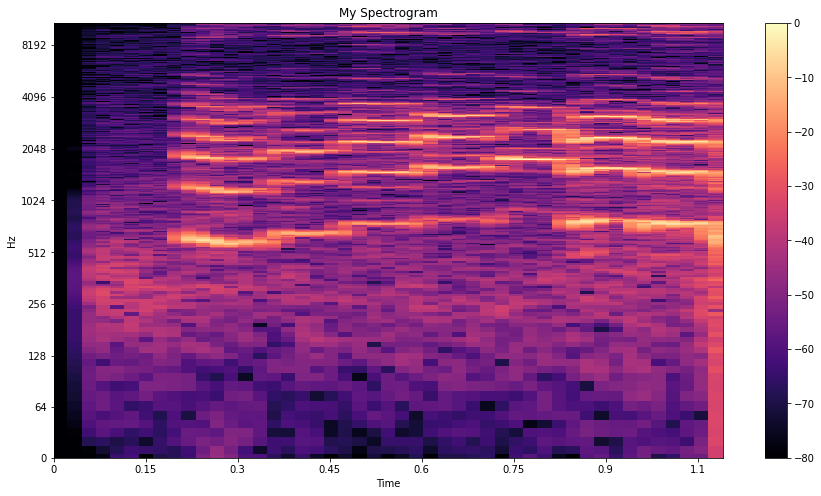

In [11]:
spec = np.abs(librosa.stft(audioSignal.read()))
spec_db = librosa.amplitude_to_db(spec, ref = np.max)

plt.figure(figsize=(15, 8))
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('My Spectrogram');